# 20201014 - Exploratory Data Analysis

Topic: Silhouettes as a tool for visualizing and assessing quality of a clustering process

This report describes a preliminary analysis of silhouettes for visualizing and assessing the quality of a clustering process. It's based on the method proposed by Rousseeuw [1] and the Python library scikit-learn was used.

## Imports and functions

The first step is to import the useful modules and define functions to be used throughout the file. Each of the functions used contains docstrings with specific details.

In [1]:
import os, inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

In [2]:
def prepare_data(flights_folder, n_observations):
    """
    Reads flight data and returns a dataframe containing flight id and the
    flight vector x.

    x = [x_1_t1,x_1_t2,...,x_1_tn,...,x_i_tj,...,x_m_t1,x_m_t2,...,x_m_tn]

    where:
        x_i_tj  <- value of the i-th flight parameter at time tj.
        m       <- total number of parameters
        n       <- number of samples for every parameter

    Similar to Cluster AD Flight, defined by Li and Hansman (2013).

    References:
    
    Li, Lishuai, and R John Hansman. 2013. “Anomaly Detection in Airline 
    Routine Operations Using Flight Data Recorder Data.” PhD thesis, 
    Cambridge, MA: Massachusetts Institute of Technology.
    """
    flights_list = os.listdir(flights_folder)

    flight_vector = []
    for flight in flights_list:
        df_flight = pd.read_csv(os.path.join(flights_folder, flight))
        touchdown_index = get_touchdown(df_flight)
        df_analysis = df_flight[touchdown_index-n_observations:touchdown_index]
        column_filter = df_flight.columns.values[df_flight.columns != 'Time']
        flight_vector.append(
                pd.melt(df_analysis.loc[:, column_filter])['value'].to_numpy()
                )

    return pd.DataFrame({'flight_id': flights_list, 'flight_vector': flight_vector})


def get_touchdown(df):
    """
    Calculates instance of touchdown (landing).
    """
    df = df.copy()
    return df.iloc[df['Altitude'].idxmax():][df['Altitude'] <= 2].index[0]


def plot_silhouette(sample_silhouette_values):
    """
    Plots the silhouette of the clustering process.
    
    Ref:
        https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

    Parameters
    ----------
    sample_silhouette_values : numpy.ndarray
        Silhouette coefficient for each sample.

    Returns
    -------
    fig : Figure
        Matplotlib figure object.
    ax : axis
        Matplotlib axis object.

    """
    fig, ax = plt.subplots()
    
    y_lower = 10
    for i in range(n_clusters_):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]
    
        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
    
        color = cm.nipy_spectral(float(i) / n_clusters_)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks(np.linspace(-1,1,11))
    
    plt.show()
    
    return fig, ax

## Inputs

The first step in the analysis is to import the flight data and preprocess it. The preprocessing steps consist on selecting only a portion of a given flight, which is done by subsetting n_observations before the touchdown. The dataframe is then melted as described by the function **prepare_data** so the flight vector is obtained.

In [3]:
currentdir = os.path.dirname(
    os.path.abspath(
        inspect.getfile(
            inspect.currentframe()
        )
    )
)

flights_folder = os.path.join(os.path.dirname(os.path.dirname(currentdir)), 'input_flights')
df_flights = prepare_data(flights_folder, n_observations=600)

print(df_flights.head())

                              flight_id  \
0  1166aa78cce1c3ef7bc246b3749eaee8.csv   
1  12fdaef5792eb79ae2685ffffc15efe1.csv   
2  135e97c93f39fed8ef95596ac27fcb41.csv   
3  142c58656bb4a84bebeef6456f454543.csv   
4  1458983def9bb5a89663afb7289d732c.csv   

                                       flight_vector  
0  [12696.0, 12675.0, 12658.0, 12648.0, 12640.0, ...  
1  [15712.0, 15700.0, 15671.0, 15662.0, 15625.0, ...  
2  [14920.0, 14930.0, 14917.0, 14894.0, 14859.0, ...  
3  [13498.0, 13496.0, 13472.0, 13463.0, 13434.0, ...  
4  [12409.0, 12412.0, 12396.0, 12376.0, 12382.0, ...  


## Preparing data for clustering

Next the data is prepared to be compatible with the sci-kit learn library. The dataframe *flight_vector* column is converted to a numpy array in which each row is a flight and each column is a feature - in this case, a flight data parameter in a given instant.

Afterwards the StandardScaler transformer standardizes the data by centering it (subtraction of the mean) and scaling it to unit variance (more info: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

A further necessary step is dimension reduction although it is not explored in this analysis which focuses only on the silhouette coefficients.

In [4]:
X = np.empty([len(df_flights.flight_vector.to_numpy()), 9000])
i = 0
for nparray in df_flights.flight_vector.to_numpy():
    X[i, :] = nparray
    i += 1

scaler = StandardScaler()
X = scaler.fit_transform(X)

## Clustering

As in the previous report, DBSCAN (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) is being used as the clustering algorithm. It is initialized with the maximum distance between two points in a neighborhood of 95. This was chosen only for demonstration purposes and it must be chosen accordinly for the input data. The selection of eps through a grid search process will be the subject of another notebook.
 
After clustering the labels are extracted from the clustering object **db** and the number of unique clusters is calculated, as well as the ones marked as noise.


In [5]:
outlier_detection = DBSCAN(eps=95, min_samples=1)
db = outlier_detection.fit(X)

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Number of clusters: {}'.format(n_clusters_))
print('Number of noise clusters: {}'.format(n_noise_))


Number of clusters: 5
Number of noise clusters: 0


## Silhouette

The silhouette of an object i is defined by \[1] as:

$s(i) = \frac{b(i) - a(i)}{max\{a(i), b(i)\}}$

where in our case, $a(i)$ is the average eucledian distance of the object to the others within its assigned cluster, and $b(i)$ is the average eucledian distance to the objects of the near cluster excluding its own.

$s(i)$ ranges from -1 to 1, representing a poor cluster assignment and a well-clustered scenario, respectively.

The silhouette for each flight is calculated with the **silhouette_score** function from scikit-learn (more info: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) and assigned to the dataframe **df_flights**. The function **plot_silhouette** is then called to generate the chart.


Average silhouette: 0.063


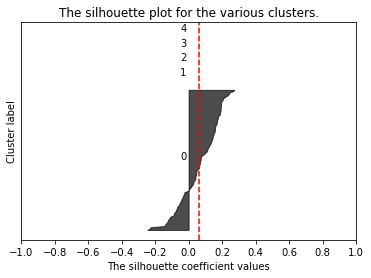

In [6]:
# Updating flights df with cluster labels
df_flights['cluster'] = labels
try:
    silhouette_avg = silhouette_score(X, db.labels_)
    sample_silhouette_values = silhouette_samples(X, db.labels_)
except:
    silhouette_avg = np.nan
    sample_silhouette_values = []

if silhouette_avg is not np.nan:
    df_flights['silhouette'] = sample_silhouette_values
    print('Average silhouette: {}'.format(round(silhouette_avg, 3)))
    plot_silhouette(sample_silhouette_values)

In [7]:
display(df_flights)

,flight_id,flight_vector,cluster,silhouette
0,1166aa78cce1c3ef7bc246b3749eaee8.csv,"[12696.0, 12675.0, 12658.0, 12648.0, 12640.0, ...",0,0.122658
1,12fdaef5792eb79ae2685ffffc15efe1.csv,"[15712.0, 15700.0, 15671.0, 15662.0, 15625.0, ...",0,-0.066713
2,135e97c93f39fed8ef95596ac27fcb41.csv,"[14920.0, 14930.0, 14917.0, 14894.0, 14859.0, ...",0,0.063219
3,142c58656bb4a84bebeef6456f454543.csv,"[13498.0, 13496.0, 13472.0, 13463.0, 13434.0, ...",0,0.169360
4,1458983def9bb5a89663afb7289d732c.csv,"[12409.0, 12412.0, 12396.0, 12376.0, 12382.0, ...",0,-0.068894
...,...,...,...,...
107,4e5dbce5225f158799ea3cef6c1f5acd.csv,"[12869.0, 12865.0, 12827.0, 12823.0, 12808.0, ...",0,0.273210
108,4ef8483fb8d64b46b6bb81886e8cb6bc.csv,"[12334.0, 12316.0, 12322.0, 12291.0, 12279.0, ...",0,-0.077685
109,4efe1a198ba8cf5951beaca3d2ebdee4.csv,"[12906.0, 12877.0, 12855.0, 12827.0, 12838.0, ...",0,0.191510
110,4f1412735ee11b25938638ef34e84383.csv,"[13603.0, 13564.0, 13572.0, 13547.0, 13531.0, ...",0,0.243720


The silhouette plot suggests several flights were misclassified as they present a negative value for the silhouette. This is also reflected on the overall silhouette score of 0.063.

## Improving the clustering results

Subsequently another DBSCAN object was instantiated with the eps value of 101, and the silhouettes were reevaluated:

Number of clusters: 2
Number of noise clusters: 0
Average silhouette: 0.332


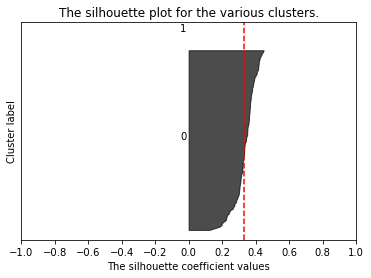

In [8]:
outlier_detection = DBSCAN(eps=101, min_samples=1)
db = outlier_detection.fit(X)

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Number of clusters: {}'.format(n_clusters_))
print('Number of noise clusters: {}'.format(n_noise_))

# Updating flights df with cluster labels
df_flights['cluster'] = labels
try:
    silhouette_avg = silhouette_score(X, db.labels_)
    sample_silhouette_values = silhouette_samples(X, db.labels_)
except:
    silhouette_avg = np.nan
    sample_silhouette_values = []

if silhouette_avg is not np.nan:
    df_flights['silhouette'] = sample_silhouette_values
    print('Average silhouette: {}'.format(round(silhouette_avg, 3)))
    plot_silhouette(sample_silhouette_values)

## Conclusions

The silhouette proved to be a very useful tool for assessing clustering quality and representing it visually, especially when dealing with high dimensional vectors such as when processing flight data. With the help of a quick silhouette plot, it was possible to detect a poor clustering process and one model hyper parameter (eps) could be adjusted for better results.

## References
\[1] P. J. Rousseeuw, “Silhouettes: A graphical aid to the interpretation and validation of cluster analysis,” Journal of Computational and Applied Mathematics, vol. 20, pp. 53–65, Nov. 1987, doi: 10.1016/0377-0427(87)90125-7.